# Script: Metabarcoding.R

In [2]:
# Libraries (Venn Diagram)
library(tidyverse)
library(VennDiagram)

# Libraries (NMDS)
library(ROBITools)
library(reshape2)
library(vegan)
library(ggalt)
library(ggpubr)
library(ggrepel)

# Libraries (Rarefaction)
library(vegan)

# Libraries (Heatmap)
#library(ComplexHeatmap)
#library(edgeR)

## Metabarcoding

In [3]:
# Data
metabar_taxa  <- read.delim("GenomeDK_Metabar/classified.txt")
metabar_count <- read.delim("GenomeDK_Metabar/DADA2_nochim.table")

In [4]:
# Select controls
m_cne <- grepl("CNE", names(metabar_count))
m_cne[1] <- TRUE
m_ntc <- grepl("NTC", names(metabar_count))
m_ntc[1] <- TRUE

cne <- metabar_count[,m_cne]
ntc <- metabar_count[,m_ntc]

# Find contaminants
cne_cont <- cne %>% mutate(total = rowSums(cne[,-1])) %>% filter(total > 0)
ntc_cont <- ntc %>% mutate(total = rowSums(ntc[,-1])) %>% filter(total > 0)

In [5]:
# Select contaminant sequences
cont <- unique(c(cne_cont$id, ntc_cont$id))

# Remove contaminants and filter
metabarcoding <- metabar_taxa %>% filter(!qseqid %in% cont) %>% filter(pident.max.best > 90)

# Select contaminants
contaminants <- metabar_taxa %>% filter(qseqid %in% cont)

# Metabarcoding diversity
tx <- metabarcoding[,c(8:14)]
dk <- length(unique(tx$kingdom[!is.na(tx$kingdom)]))
dp <- length(unique(tx$phylum[!is.na(tx$phylum)]))
dc <- length(unique(tx$class[!is.na(tx$class)]))
do <- length(unique(tx$order[!is.na(tx$order)]))
df <- length(unique(tx$family[!is.na(tx$family)]))
dg <- length(unique(tx$genus[!is.na(tx$genus)]))
ds <- length(unique(tx$species[!is.na(tx$species)]))

message(paste("Metabarcoding diversity: kingdom: ", dk, ", phylum: ", dp, ", class: ", dc, ", order: ", do, ", family: ", df, ", genus: ", dg, " and species: ", ds, sep=""))

Metabarcoding diversity: kingdom: 3, phylum: 46, class: 155, order: 432, family: 808, genus: 1292 and species: 2058



In [6]:
# nMDS
nMDS_plot <- function(reads, samples) {
  # Create scores
  nmds = metaMDS(reads, distance = "bray")
  nmds.sites.scores = as.data.frame(vegan::scores(nmds)$sites)
  #nmds.species.scores = as.data.frame(vegan::scores(nmds)$species)

  # Add metadata
  nmds.sites.scores$sample = samples$sample
  nmds.sites.scores$pore = samples$pore

  # Factorize
  nmds.sites.scores <- nmds.sites.scores %>%
    dplyr::mutate(pore=factor(pore, levels=c("GP", "0.2", "1.2","5.0", "8.0")))

  # Plot
  p <- ggplot(nmds.sites.scores, aes(x = NMDS1, y = NMDS2, label=sample)) + 
    geom_point(size = 4, aes(colour = pore)) +
    geom_encircle(aes(fill = pore), s_shape = 1, expand = 0,
                  alpha = 0.2, color = "black", show.legend = FALSE) +
    geom_text_repel() +
    labs(colour='Filter type') +
    theme_classic() %+replace% theme(
      axis.text.x = element_text(size=14),
      axis.text.y = element_text(size=14),
      axis.title = element_text(size=20),
      legend.title = element_text(size=18, face="bold"),
      legend.text = element_text(size=16))
  
  return(p)
}

In [6]:
# Remove contaminant from counts
metabar_count_clean <- metabar_count %>% filter(!id %in% cont)
metabar_count_clean <- metabar_count_clean[,!grepl("NTC", names(metabar_count_clean))]
metabar_count_clean <- metabar_count_clean[,!grepl("CNE", names(metabar_count_clean))]

In [7]:
# Rename columns
cols <- colnames(metabar_count_clean)

clean_cols <- str_replace(str_replace(cols[-1], "sample.", ""),"u","")
clean_cols <- str_replace(clean_cols, "GP1", "EN0.2A")
clean_cols <- str_replace(clean_cols, "GP2", "EN0.2B")
clean_cols <- str_replace(clean_cols, "GP3", "EN0.2C")
clean_cols <- str_replace(clean_cols, "1_0.2", "OP0.2A")
clean_cols <- str_replace(clean_cols, "2_0.2", "OP0.2B")
clean_cols <- str_replace(clean_cols, "3_0.2", "OP0.2C")
clean_cols <- str_replace(clean_cols, "1_1.2", "OP1.2A")
clean_cols <- str_replace(clean_cols, "2_1.2", "OP1.2B")
clean_cols <- str_replace(clean_cols, "3_1.2", "OP1.2C")
clean_cols <- str_replace(clean_cols, "1_5.0", "OP5.0A")
clean_cols <- str_replace(clean_cols, "2_5.0", "OP5.0B")
clean_cols <- str_replace(clean_cols, "3_5.0", "OP5.0C")
clean_cols <- str_replace(clean_cols, "1_8.0", "OP8.0A")
clean_cols <- str_replace(clean_cols, "2_8.0", "OP8.0B")
clean_cols <- str_replace(clean_cols, "3_8.0", "OP8.0C")

colnames(metabar_count_clean)[-1] <-  clean_cols
cols <- colnames(metabar_count_clean)

### Raw rarefaction curves

In [8]:
# GP
gp1 <- cols[grepl("EN0.2A", cols)]
gp2 <- cols[grepl("EN0.2B", cols)]
gp3 <- cols[grepl("EN0.2C", cols)]
# A02
a02 <- cols[grepl("OP0.2A", cols)]
b02 <- cols[grepl("OP0.2B", cols)]
c02 <- cols[grepl("OP0.2C", cols)]
# A02
a12 <- cols[grepl("OP1.2A", cols)]
b12 <- cols[grepl("OP1.2B", cols)]
c12 <- cols[grepl("OP1.2C", cols)]
# A02
a50 <- cols[grepl("OP5.0A", cols)]
b50 <- cols[grepl("OP5.0B", cols)]
c50 <- cols[grepl("OP5.0C", cols)]
# A02
a80 <- cols[grepl("OP8.0A", cols)]
b80 <- cols[grepl("OP8.0B", cols)]
c80 <- cols[grepl("OP8.0C", cols)]

In [9]:
# Colors
colors <- c("#F8766D", "#B79F00", "#00BF7D", "#00B0F6", "#E76BF3")

In [10]:
# Raw curve
cc <- t(metabar_count_clean)
colnames(cc) <- cc[1,]
cc <- cc[-1,]
cc <- apply(cc, 2, as.numeric)
rownames(cc) <- colnames(metabar_count_clean)[-1]

In [12]:
cc[gp1,]

,seq1,seq3,seq4,seq5,seq6,seq9,seq11,seq12,seq13,seq14,⋯,seq16880,seq16881,seq16882,seq16883,seq16884,seq16885,seq16886,seq16887,seq16888,seq16889
EN0.2A_1,45768,13,25961,10,23929,21422,45389,28367,19451,32021,⋯,0,0,0,0,0,0,0,0,0,0
EN0.2A_2,59607,33,21004,25,21595,23848,38323,15254,18499,32279,⋯,0,0,1,0,0,0,0,0,0,0
EN0.2A_3,44942,10,18424,16,17799,16995,33205,13061,14793,24856,⋯,0,0,0,0,0,0,0,0,0,0
EN0.2A_4,52526,29,22346,16,20681,19873,41192,21331,18359,31081,⋯,0,0,0,0,0,0,0,0,0,0


In [109]:
# GP
raremax <- min(rowSums(cc[gp1,]))
png("GenomeDK_Metabar/raw_curves/raw_curve.replicates.GP1.png", width=2000, height=2000, res=300)
rarecurve(cc[gp1,], step = 20, sample = raremax, col = colors[1], cex = 0.6)
dev.off()

raremax <- min(rowSums(cc[gp2,]))
png("GenomeDK_Metabar/raw_curves/raw_curve.replicates.GP2.png", width=2000, height=2000, res=300)
rarecurve(cc[gp2,], step = 20, sample = raremax, col = colors[1], cex = 0.6)
dev.off()

raremax <- min(rowSums(cc[gp3,]))
png("GenomeDK_Metabar/raw_curves/raw_curve.replicates.GP3.png", width=2000, height=2000, res=300)
rarecurve(cc[gp3,], step = 20, sample = raremax, col = colors[1], cex = 0.6)
dev.off()

Warning message in rarecurve(cc[gp2, ], step = 20, sample = raremax, col = colors[1], :
“most observed count data have counts 1, but smallest count is 2”


png 
  2

Warning message in rarecurve(cc[gp3, ], step = 20, sample = raremax, col = colors[1], :
“most observed count data have counts 1, but smallest count is 2”


png 
  2

In [110]:
# 0.2
raremax <- min(rowSums(cc[a02,]))
png("GenomeDK_Metabar/raw_curves/raw_curve.replicates.A02.png", width=2000, height=2000, res=300)
rarecurve(cc[a02,], step = 20, sample = raremax, col = colors[2], cex = 0.6)
dev.off()

raremax <- min(rowSums(cc[b02,]))
png("GenomeDK_Metabar/raw_curves/raw_curve.replicates.B02.png", width=2000, height=2000, res=300)
rarecurve(cc[b02,], step = 20, sample = raremax, col = colors[2], cex = 0.6)
dev.off()

raremax <- min(rowSums(cc[c02,]))
png("GenomeDK_Metabar/raw_curves/raw_curve.replicates.C02.png", width=2000, height=2000, res=300)
rarecurve(cc[c02,], step = 20, sample = raremax, col = colors[2], cex = 0.6)
dev.off()

png 
  2

png 
  2

png 
  2

In [111]:
# 1.2
raremax <- min(rowSums(cc[a12,]))
png("GenomeDK_Metabar/raw_curves/raw_curve.replicates.A12.png", width=2000, height=2000, res=300)
rarecurve(cc[a12,], step = 20, sample = raremax, col = colors[3], cex = 0.6)
dev.off()

raremax <- min(rowSums(cc[b12,]))
png("GenomeDK_Metabar/raw_curves/raw_curve.replicates.B12.png", width=2000, height=2000, res=300)
rarecurve(cc[b12,], step = 20, sample = raremax, col = colors[3], cex = 0.6)
dev.off()

raremax <- min(rowSums(cc[c12,]))
png("GenomeDK_Metabar/raw_curves/raw_curve.replicates.C12.png", width=2000, height=2000, res=300)
rarecurve(cc[c12,], step = 20, sample = raremax, col = colors[3], cex = 0.6)
dev.off()

Warning message in rarecurve(cc[a12, ], step = 20, sample = raremax, col = colors[3], :
“most observed count data have counts 1, but smallest count is 2”


png 
  2

png 
  2

Warning message in rarecurve(cc[c12, ], step = 20, sample = raremax, col = colors[3], :
“most observed count data have counts 1, but smallest count is 2”


png 
  2

In [112]:
# 5.0
raremax <- min(rowSums(cc[a50,]))
png("GenomeDK_Metabar/raw_curves/raw_curve.replicates.A50.png", width=2000, height=2000, res=300)
rarecurve(cc[a50,], step = 20, sample = raremax, col = colors[4], cex = 0.6)
dev.off()

raremax <- min(rowSums(cc[b50,]))
png("GenomeDK_Metabar/raw_curves/raw_curve.replicates.B50.png", width=2000, height=2000, res=300)
rarecurve(cc[b50,], step = 20, sample = raremax, col = colors[4], cex = 0.6)
dev.off()

raremax <- min(rowSums(cc[c50,]))
png("GenomeDK_Metabar/raw_curves/raw_curve.replicates.C50.png", width=2000, height=2000, res=300)
rarecurve(cc[c50,], step = 20, sample = raremax, col = colors[4], cex = 0.6)
dev.off()

Warning message in rarecurve(cc[a50, ], step = 20, sample = raremax, col = colors[4], :
“most observed count data have counts 1, but smallest count is 2”


png 
  2

Warning message in rarecurve(cc[b50, ], step = 20, sample = raremax, col = colors[4], :
“most observed count data have counts 1, but smallest count is 2”


png 
  2

Warning message in rarecurve(cc[c50, ], step = 20, sample = raremax, col = colors[4], :
“most observed count data have counts 1, but smallest count is 2”


png 
  2

In [100]:
# 8.0
raremax <- min(rowSums(cc[a80,]))
png("GenomeDK_Metabar/raw_curves/raw_curve.replicates.A80.png", width=2000, height=2000, res=300)
rarecurve(cc[a80,], step = 20, sample = raremax, col = colors[5], cex = 0.6)
dev.off()

raremax <- min(rowSums(cc[b80,]))
png("GenomeDK_Metabar/raw_curves/raw_curve.replicates.B80.png", width=2000, height=2000, res=300)
rarecurve(cc[b80,], step = 20, sample = raremax, col = colors[5], cex = 0.6)
dev.off()

raremax <- min(rowSums(cc[c80,]))
png("GenomeDK_Metabar/raw_curves/raw_curve.replicates.C80.png", width=2000, height=2000, res=300)
rarecurve(cc[c80,], step = 20, sample = raremax, col = colors[5], cex = 0.6)
dev.off()

Warning message in rarecurve(cc[a80, ], step = 20, sample = raremax, col = colors[5], :
“most observed count data have counts 1, but smallest count is 2”


png 
  2

png 
  2

Warning message in rarecurve(cc[c80, ], step = 20, sample = raremax, col = colors[5], :
“most observed count data have counts 1, but smallest count is 2”


png 
  2

### Accumulation plots

Warning message in cor(x > 0):
“the standard deviation is zero”
'nperm' >= set of all permutations: complete enumeration.

Set of permutations < 'minperm'. Generating entire set.



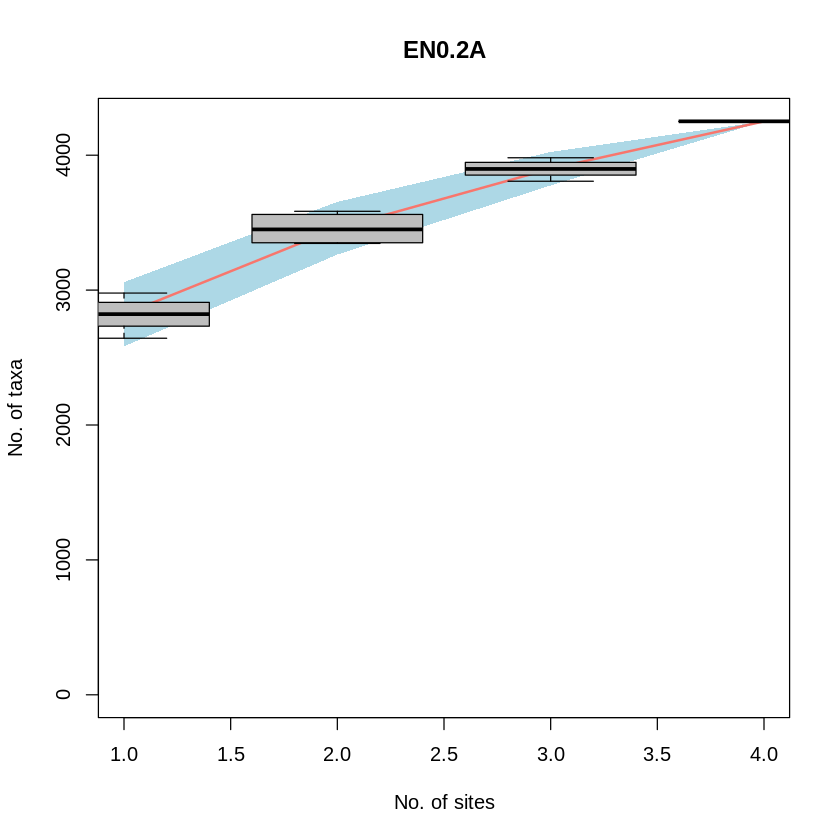

In [11]:
# GP1
accum <- specaccum(cc[gp1,], method = "exact", permutations = 100, conditioned =TRUE, gamma = "jack1", w = NULL)
accum2 <- specaccum(cc[gp1,], "random")
plot(accum, ci.type="poly", col=colors[1], lwd=2, ci.lty=0, ci.col="lightblue",xlab="No. of sites",ylab="No. of taxa",main="EN0.2A")
boxplot(accum2, col="gray", add=TRUE, pch="+")

In [27]:
# All (Raw)
accum <- specaccum(cc, method = "exact", permutations = 100, conditioned =TRUE, gamma = "jack1", w = NULL)
accum2 <- specaccum(cc, "random")
png("GenomeDK_Metabar/accum_curve.raw.png", width=2000, height=2000, res=300)
plot(accum, ci.type="poly", col="black", lwd=2, ci.lty=0, ci.col="gold",xlab="No. of sites",ylab="No. of taxa",main="")
boxplot(accum2, col="gray", add=TRUE, pch="+")
dev.off()

Warning message in cor(x > 0):
“the standard deviation is zero”


png 
  2

### Rarefaction: Metabarcoding

In [33]:
# # Function: rarefy replicates
# rarefy_reps <- function(df, columns, name) {
#     cs2mr <- df[,c(columns,"id")]
#     colnames(cs2mr)[-ncol(cs2mr)] <- paste("sample:", colnames(cs2mr)[-ncol(cs2mr)], sep="")
#     # Save temportal file
#     f = paste('GenomeDK_Metabar/temporal/', name, '_for_rep_rarefy.txt', sep="")
#     write.table(cs2mr, file=f, quote=FALSE, sep='\t', col.names = NA, row.names=TRUE)
#     # Load temporal file into ROBITools
#     dfimp <- import.metabarcoding.data(f)
#     # Compute median
#     mdn <- median(rowSums(dfimp@reads))
#     # Median Rarefy
#     dfrar <- ROBITools::rarefy(dfimp, n = mdn, MARGIN="sample")
#     # Return
#     return(dfrar)
# }

In [ ]:
# # GP1
# rc_gp1 <- rarefy_reps(metabar_count_clean, gp1, "EN0.2A")
# png("GenomeDK_Metabar/rarefied_curves/rarefied_curve.replicates.GP1.png", width=2000, height=2000, res=300)
# rarecurve(rc_gp1@reads, step = 20, col = colors[1], cex = 0.6)
# dev.off()

In [ ]:
# Function: Aggregate replicates
# collapse_reps <- function(reads) {
#     # Name and median
#     sample <- unique(str_replace(rownames(reads), "_[0-9]", ""))
#     values <- colSums(rc_l[[1]]@reads)
#     # Table
#     df <- t(as.data.frame(values))
#     rownames(df) <- sample
#     # Return
#     return(df)
# }

# Create table
# rc_l <- list(rc_gp1, rc_gp2, rc_gp3,
#      rc_a02, rc_b02, rc_c02,
#      rc_a12, rc_b12, rc_c12,
#      rc_a50, rc_b50, rc_c50,
#      rc_a80, rc_b80, rc_c80)

# rc <- lapply(rc_l, function(x) collapse_reps(x@reads))
# rc <- do.call("rbind", rc)

# Rarefaction: Samples
# rc

In [14]:
cs2mr <- metabar_count_clean
colnames(cs2mr)[-1] <- paste("sample:", colnames(cs2mr)[-1], sep="")
f = 'GenomeDK_Metabar/temporal/all_for_rep_rarefy.txt'
write.table(cs2mr, file=f, quote=FALSE, sep='\t', col.names = NA, row.names=TRUE)

In [15]:
dfimp <- import.metabarcoding.data(f)
df_mod <- dfimp$samples %>% mutate(replicate =  dfimp$samples$sample) %>% mutate(sample = gsub("_[0-9]", "", dfimp$samples$sample))
dfimp@samples = df_mod

In [16]:
# Rarefy metabarcoding
median = median(rowSums(dfimp$reads[dfimp$samples$replicate,]))
raw.rarefy = ROBITools::rarefy(dfimp, n=median, MARGIN='sample')
tmp = ROBITools:::aggregate.metabarcoding.data(raw.rarefy, by=list(sample=raw.rarefy$samples$sample), FUN=sum)
minimum = min(rowSums(tmp$reads[tmp$samples$sample,]))
final.rarefy = ROBITools::rarefy(tmp, n=minimum, MARGIN = 'sample')

In [ ]:
# mdns <- dfimp@reads %>% melt(id.vars = rownames(.)) %>%
# mutate(sample = gsub("_[0-9]", "",Var1)) %>% select(-Var2) %>%
# group_by(sample,Var1) %>% summarise(value = sum(value)) %>% ungroup() %>% 
# group_by(sample) %>% summarise(median = median(value))

In [ ]:
# median_threshold <- mdns$median
# names(median_threshold) <- mdns$sample
# median_threshold

In [53]:
# reads <- as.data.frame(dfimp[a12,]$reads)
# reads$id <- rownames(reads)
# melt(reads, id.vars = "id") %>% ggplot() + geom_boxplot(aes(x=id, y=log(value)), color=colors[3]) +
# labs(x="Samples", y="Log(Counts)") +
# theme_bw() %+replace% theme(axis.text.x = element_text(angle = 90, size=14),
#                                  axis.text.y = element_text(size=18),
#                                  axis.title = element_text(size=20),
#                                  legend.title = element_text(size=18, face="bold"),
#                                  legend.text = element_text(size=16))

In [52]:
# test <- ROBITools::rarefy(dfimp[a12,], n=median_threshold["OP1.2A"], MARGIN='sample')
# reads <- as.data.frame(test$reads)
# reads$id <- rownames(reads)
# melt(reads, id.vars = "id") %>% ggplot() + geom_boxplot(aes(x=id, y=log(value)), color=colors[3]) +
# labs(x="Samples", y="Log(Counts)") +
# theme_bw() %+replace% theme(axis.text.x = element_text(angle = 90, size=14),
#                                  axis.text.y = element_text(size=18),
#                                  axis.title = element_text(size=20),
#                                  legend.title = element_text(size=18, face="bold"),
#                                  legend.text = element_text(size=16))

In [17]:
# Boxplot: raw metabarcoding counts
col <- c(rep("#F8766D",12), rep("#B79F00",12), rep("#00BF7D",12), rep("#00B0F6",12), rep("#E76BF3",12))
reads <- as.data.frame(dfimp$reads)
reads$id <- rownames(reads)
p <- melt(reads, id.vars = "id") %>% ggplot() + geom_boxplot(aes(x=id, y=log(value)), color=col) +
labs(x="Samples", y="Log(Counts)") +
theme_bw() %+replace% theme(axis.text.x = element_text(angle = 90, size=14),
                                 axis.text.y = element_text(size=18),
                                 axis.title = element_text(size=20),
                                 legend.title = element_text(size=18, face="bold"),
                                 legend.text = element_text(size=16))

png(file="GenomeDK_Metabar/boxplot.raw.png", width=3200, height=2000, res=300)
p
dev.off()

Warning message:
“Removed 826560 rows containing non-finite values (`stat_boxplot()`).”


png 
  2

Warning message:
“Removed 827398 rows containing non-finite values (`stat_boxplot()`).”


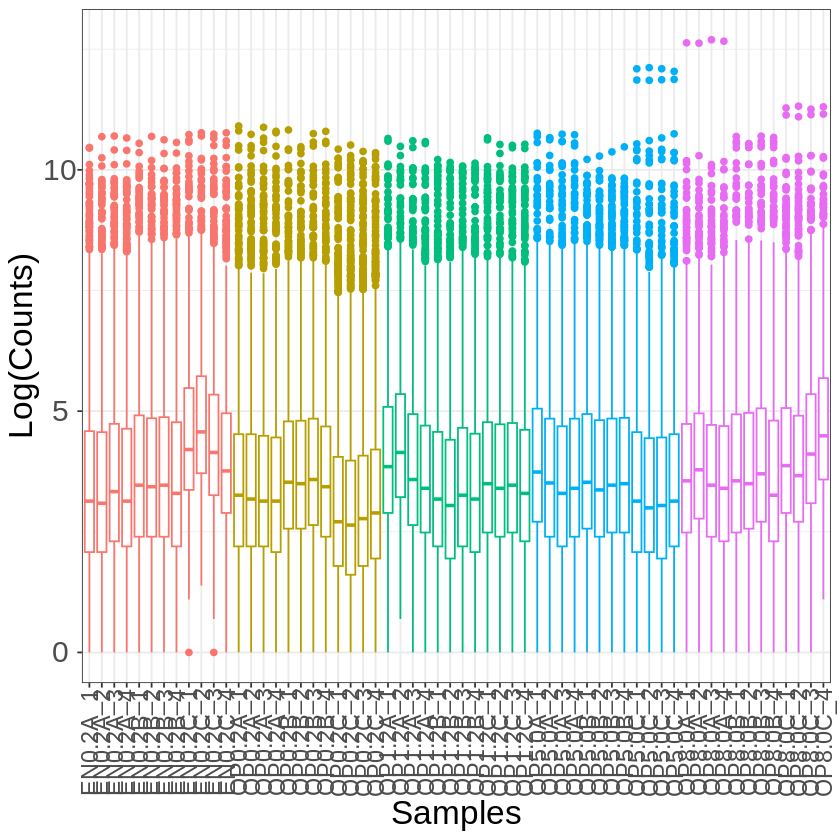

In [79]:
# Boxplot: median rarefy metabarcoding counts
col <- c(rep("#F8766D",12), rep("#B79F00",12), rep("#00BF7D",12), rep("#00B0F6",12), rep("#E76BF3",12))
reads <- as.data.frame(raw.rarefy$reads)
reads$id <- rownames(reads)
p <- melt(reads, id.vars = "id") %>% ggplot() + geom_boxplot(aes(x=id, y=log(value)), color=col) +
labs(x="Samples", y="Log(Counts)") +
theme_bw() %+replace% theme(axis.text.x = element_text(angle = 90, size=14),
                                 axis.text.y = element_text(size=18),
                                 axis.title = element_text(size=20),
                                 legend.title = element_text(size=18, face="bold"),
                                 legend.text = element_text(size=16))

png(file="GenomeDK_Metabar/boxplot.median_rarefy.png", width=3200, height=2000, res=300)
p
dev.off()

Warning message:
“Removed 186761 rows containing non-finite values (`stat_boxplot()`).”


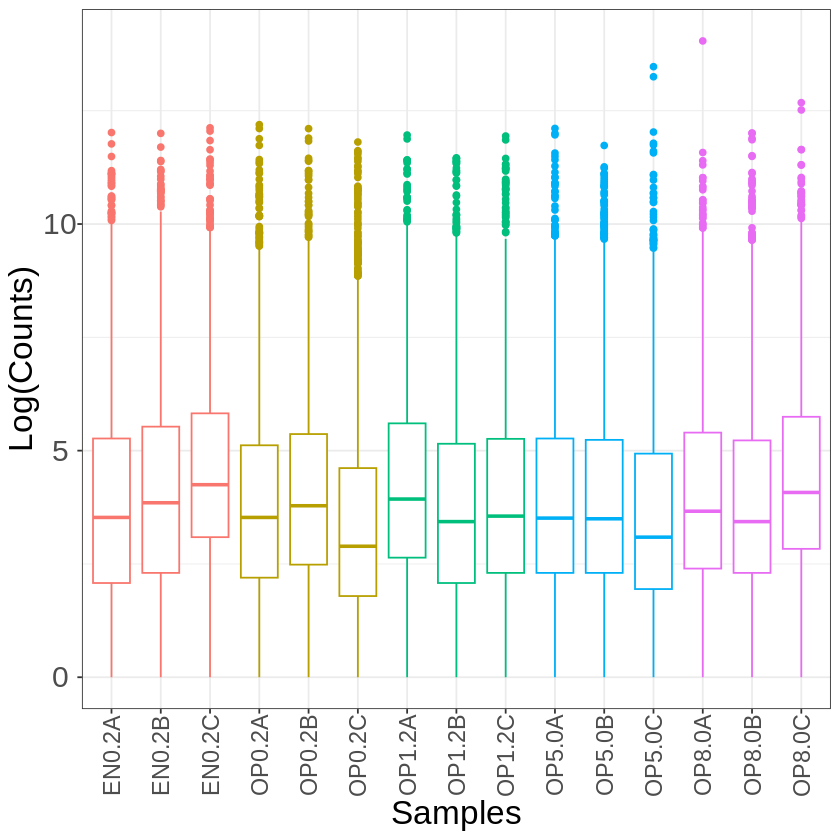

In [83]:
# Boxplot: minimum rarefy metabarcoding counts
col <- c(rep("#F8766D",3), rep("#B79F00",3), rep("#00BF7D",3), rep("#00B0F6",3), rep("#E76BF3",3))
reads <- as.data.frame(final.rarefy$reads)
reads$id <- rownames(reads)
p <- melt(reads, id.vars = "id") %>% ggplot() + geom_boxplot(aes(x=id, y=log(value)), color=col) +
labs(x="Samples", y="Log(Counts)") +
theme_bw() %+replace% theme(axis.text.x = element_text(angle = 90, size=14),
                                 axis.text.y = element_text(size=18),
                                 axis.title = element_text(size=20),
                                 legend.title = element_text(size=18, face="bold"),
                                 legend.text = element_text(size=16))

png(file="GenomeDK_Metabar/boxplot.minimum_rarefy.png", width=2300, height=2000, res=300)
p
dev.off()

### Rarefied curves

In [55]:
# GP1
png("GenomeDK_Metabar/rarefied_curves/rarefied_curve.replicates.GP1.png", width=2000, height=2000, res=300)
rarecurve(raw.rarefy@reads[gp1,], step = 20, col = colors[1], cex = 0.6, ylab="No. of taxa")
dev.off()

png 
  2

In [56]:
# GP2
png("GenomeDK_Metabar/rarefied_curves/rarefied_curve.replicates.GP2.png", width=2000, height=2000, res=300)
rarecurve(raw.rarefy@reads[gp2,], step = 20, col = colors[1], cex = 0.6, ylab="No. of taxa")
dev.off()

png 
  2

In [57]:
# GP3
png("GenomeDK_Metabar/rarefied_curves/rarefied_curve.replicates.GP3.png", width=2000, height=2000, res=300)
rarecurve(raw.rarefy@reads[gp3,], step = 20, col = colors[1], cex = 0.6, ylab="No. of taxa")
dev.off()

png 
  2

In [58]:
# A02
png("GenomeDK_Metabar/rarefied_curves/rarefied_curve.replicates.A02.png", width=2000, height=2000, res=300)
rarecurve(raw.rarefy@reads[a02,], step = 20, col = colors[2], cex = 0.6, ylab="No. of taxa")
dev.off()

png 
  2

In [59]:
# B02
png("GenomeDK_Metabar/rarefied_curves/rarefied_curve.replicates.B02.png", width=2000, height=2000, res=300)
rarecurve(raw.rarefy@reads[b02,], step = 20, col = colors[2], cex = 0.6, ylab="No. of taxa")
dev.off()

png 
  2

In [60]:
# C02
png("GenomeDK_Metabar/rarefied_curves/rarefied_curve.replicates.C02.png", width=2000, height=2000, res=300)
rarecurve(raw.rarefy@reads[c02,], step = 20, col = colors[2], cex = 0.6, ylab="No. of taxa")
dev.off()

png 
  2

In [61]:
# A12
png("GenomeDK_Metabar/rarefied_curves/rarefied_curve.replicates.A12.png", width=2000, height=2000, res=300)
rarecurve(raw.rarefy@reads[a12,], step = 20, col = colors[3], cex = 0.6, ylab="No. of taxa")
dev.off()

png 
  2

In [62]:
# B12
png("GenomeDK_Metabar/rarefied_curves/rarefied_curve.replicates.B12.png", width=2000, height=2000, res=300)
rarecurve(raw.rarefy@reads[b12,], step = 20, col = colors[3], cex = 0.6, ylab="No. of taxa")
dev.off()

png 
  2

In [63]:
# C12
png("GenomeDK_Metabar/rarefied_curves/rarefied_curve.replicates.C12.png", width=2000, height=2000, res=300)
rarecurve(raw.rarefy@reads[c12,], step = 20, col = colors[3], cex = 0.6, ylab="No. of taxa")
dev.off()

png 
  2

In [64]:
# A50
png("GenomeDK_Metabar/rarefied_curves/rarefied_curve.replicates.A50.png", width=2000, height=2000, res=300)
rarecurve(raw.rarefy@reads[a50,], step = 20, col = colors[4], cex = 0.6, ylab="No. of taxa")
dev.off()

png 
  2

In [65]:
# B50
png("GenomeDK_Metabar/rarefied_curves/rarefied_curve.replicates.B50.png", width=2000, height=2000, res=300)
rarecurve(raw.rarefy@reads[b50,], step = 20, col = colors[4], cex = 0.6, ylab="No. of taxa")
dev.off()

png 
  2

In [66]:
# C50
png("GenomeDK_Metabar/rarefied_curves/rarefied_curve.replicates.C50.png", width=2000, height=2000, res=300)
rarecurve(raw.rarefy@reads[c50,], step = 20, col = colors[4], cex = 0.6, ylab="No. of taxa")
dev.off()

png 
  2

In [67]:
# A80
png("GenomeDK_Metabar/rarefied_curves/rarefied_curve.replicates.A80.png", width=2000, height=2000, res=300)
rarecurve(raw.rarefy@reads[a80,], step = 20, col = colors[5], cex = 0.6, ylab="No. of taxa")
dev.off()

png 
  2

In [68]:
# B80
png("GenomeDK_Metabar/rarefied_curves/rarefied_curve.replicates.B80.png", width=2000, height=2000, res=300)
rarecurve(raw.rarefy@reads[b80,], step = 20, col = colors[5], cex = 0.6, ylab="No. of taxa")
dev.off()

png 
  2

In [69]:
# C80
png("GenomeDK_Metabar/rarefied_curves/rarefied_curve.replicates.C80.png", width=2000, height=2000, res=300)
rarecurve(raw.rarefy@reads[c80,], step = 20, col = colors[5], cex = 0.6, ylab="No. of taxa")
dev.off()

png 
  2

In [66]:
# All samples
col <- c(rep("#F8766D",3), rep("#B79F00",3), rep("#00BF7D",3), rep("#00B0F6",3), rep("#E76BF3",3))
png("GenomeDK_Metabar/rarefied_curves/rarefied_curve.all.png", width=2000, height=2000, res=300)
rarecurve(final.rarefy@reads, step = 20, col = col , cex = 0.6, ylab="No. of taxa")
dev.off()

png 
  2

## Shotgun

In [48]:
# --------
## Shotgun
# --------
shotgun_taxa_count <- read.delim("GenomeDK_LCA/counts.lca.rarefy.tsv")

# Clean shotgun
#shotgun <- shotgun_taxa_count %>% filter(!species %in% contaminants$species)

# Select Eukaryota
shotgun_eu <- shotgun_taxa_count %>% filter(superkingdom == "Eukaryota")

In [23]:
col <- c(rep("#F8766D",3), rep("#B79F00",3), rep("#00BF7D",3), rep("#00B0F6",3), rep("#E76BF3",3))

In [20]:
# All identified taxa rarecurve
sc <- shotgun_taxa_count[,c(9:23)]
sc <- t(sc)
colnames(sc) <- paste("tax", 1:ncol(sc), sep="")

In [144]:
# This one does not make sense if we do not trust the identifications
png("GenomeDK_LCA/rarefied_curve.all.png", width=2000, height=2000, res=300)
rarecurve(sc, step = 20, col = col, cex = 0.6)
dev.off()

png 
  2

In [24]:
# Phylum rarecurve
sc_phyl <- shotgun_taxa_count[,c(3,9:23)] %>% melt() %>% group_by(phylum, variable) %>%
summarise(value = sum(value)) %>% drop_na(phylum) %>% dcast(variable~phylum)
rownames(sc_phyl) <- sc_phyl$variable
sc_phyl <- sc_phyl[,-1]
sc_phyl <- as.matrix(sc_phyl)

Using phylum as id variables

`summarise()` has grouped output by 'phylum'. You can override using the `.groups`
argument.


In [25]:
png("GenomeDK_LCA/rarefied_curve.phyla_noNA.png", width=2000, height=2000, res=300)
rarecurve(sc_phyl, step = 20, col = col, cex = 0.6, ylab="Phylum")
dev.off()

png 
  2

**Accumulation**

In [26]:
# Phylum
accum <- specaccum(sc_phyl, method = "exact", permutations = 100, conditioned =TRUE, gamma = "jack1", w = NULL)
accum2 <- specaccum(sc_phyl, "random")
png("GenomeDK_LCA/accum_curve.phyla_noNA.png", width=2000, height=2000, res=300)
plot(accum, ci.type="poly", col="black", lwd=2, ci.lty=0, ci.col="royalblue",xlab="No. of samples",ylab="No. of Phyla",main="Shotgun")
boxplot(accum2, col="gray", add=TRUE, pch="+")
dev.off()

Warning message in cor(x > 0):
“the standard deviation is zero”


png 
  2

## Comparison

In [46]:
# Function
display_venn <- function(x, ...){
  grid.newpage()
  venn_object <- venn.diagram(x, filename = NULL, ...)
  grid.draw(venn_object)
}

In [44]:
# Clean rarefied metabarcoding
remove <- colnames(final.rarefy@reads)[colSums(final.rarefy@reads) == 0]
metbar <- metabarcoding[!metabarcoding$qseqid %in% remove,]

In [54]:
table(taxa$metabarcoding %in% taxa$shotgun_eu)
table(taxa$shotgun_eu %in% taxa$metabarcoding)


FALSE  TRUE 
    6    39 


FALSE  TRUE 
    9    39 

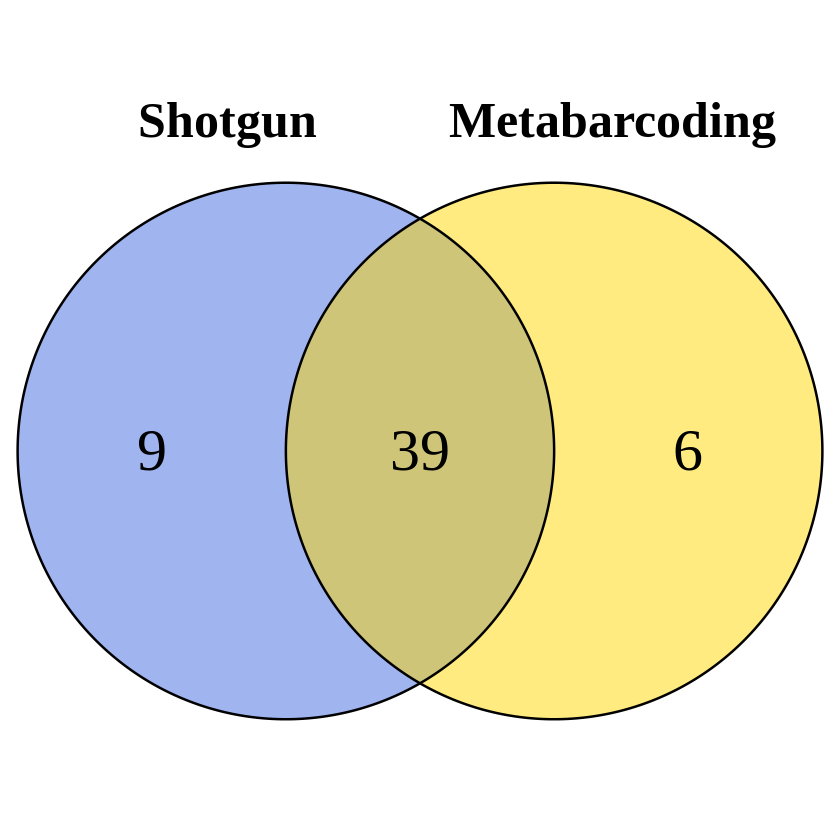

In [55]:
# Phylum
phyl_metabar <- unique(metbar$phylum[!is.na(metbar$phylum)])
phyl_shotgun <- unique(shotgun_eu$phylum[!is.na(shotgun_eu$phylum)])
taxa <- list(metabarcoding = phyl_metabar, shotgun_eu = phyl_shotgun)

# Venn Diagram (Saved manually)
display_venn(taxa,
             category.names = c("Metabarcoding", "Shotgun"),
             fill = c("gold", "royalblue"),
             cex = 3,
             cat.cex = 2.5, cat.fontface = "bold", 
             cat.pos = c(10,-10),
             cat.dist = c(0.05, 0.05),
             scaled = F)

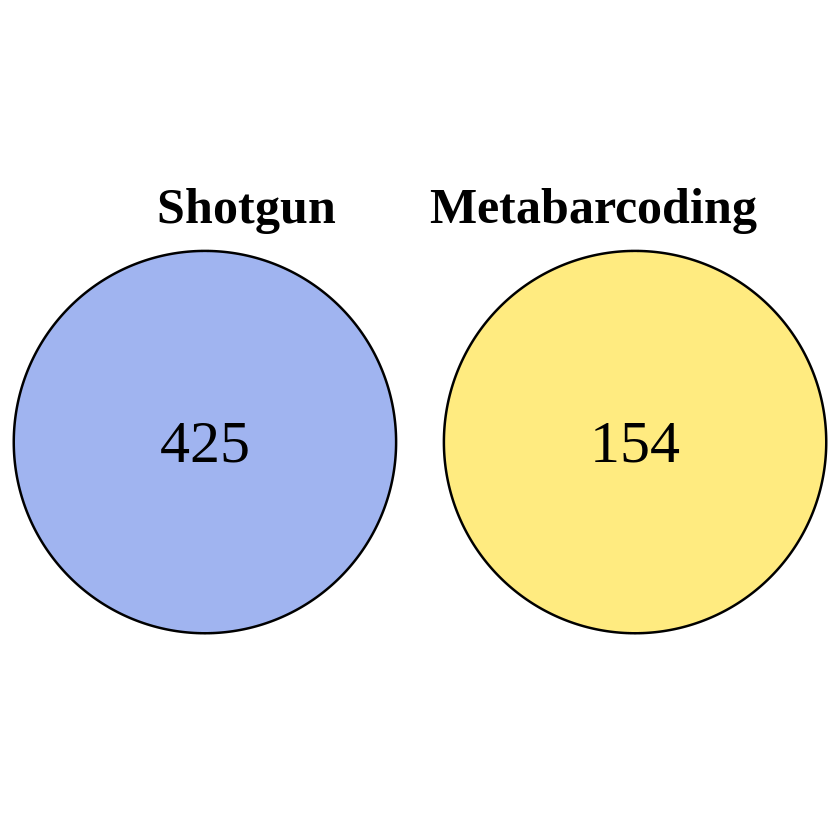

In [57]:
# Class
cla_metabar <- unique(metbar$class[!is.na(metbar$class)])
cla_shotgun <- unique(shotgun_eu$class[!is.na(shotgun_eu$class)])
taxa <- list(metabarcoding = cla_metabar, shotgun_eu = cla_shotgun)

# Venn Diagram (Saved manually)
display_venn(taxa,
             category.names = c("Metabarcoding", "Shotgun"),
             fill = c("gold", "royalblue"),
             cex = 3,
             cat.cex = 2.5, cat.fontface = "bold",
             cat.pos = c(-10,10),
             cat.dist = c(0.05, 0.05),
             scaled = F)

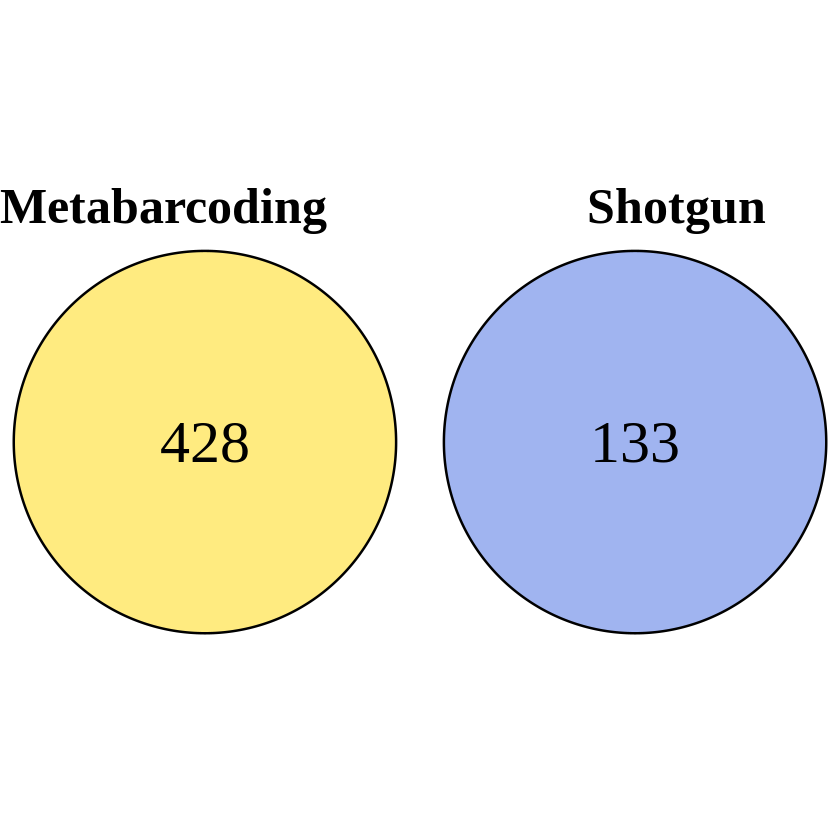

In [58]:
# Order
ord_metabar <- unique(metbar$order[!is.na(metbar$order)])
ord_shotgun <- unique(shotgun_eu$order[!is.na(shotgun_eu$order)])
taxa <- list(metabarcoding = ord_metabar, shotgun_eu = ord_shotgun)

# Venn Diagram (Saved manually)
display_venn(taxa,
             category.names = c("Metabarcoding", "Shotgun"),
             fill = c("gold", "royalblue"),
             cex = 3,
             cat.cex = 2.5, cat.fontface = "bold",
             cat.pos = c(-10,10),
             cat.dist = c(0.05, 0.05),
             scaled = F)

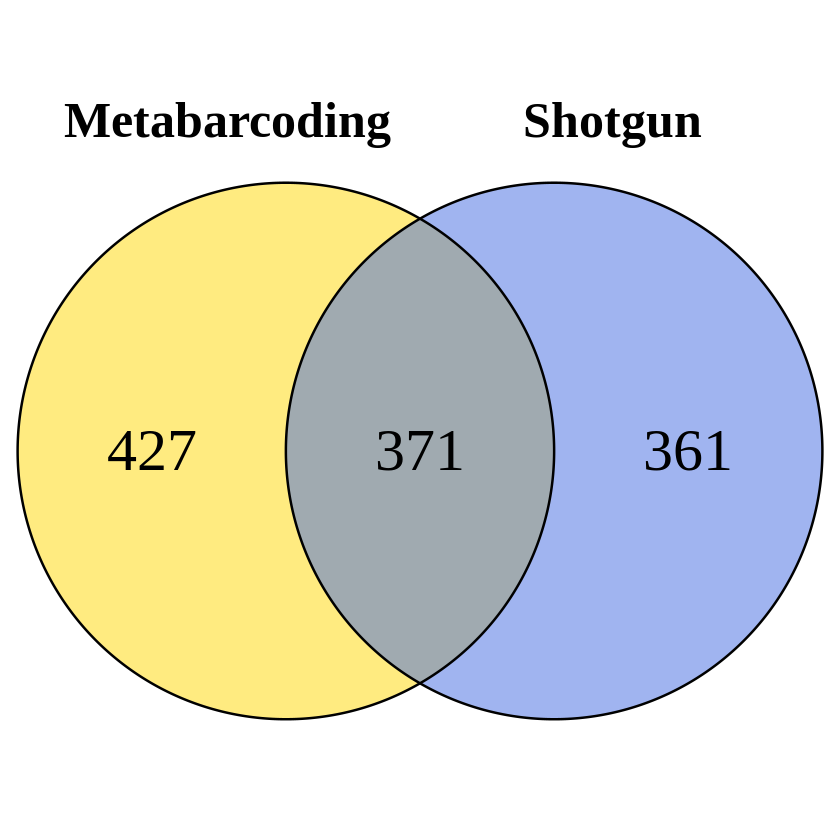

In [59]:
# Family
fam_metabar <- unique(metbar$family[!is.na(metbar$family)])
fam_shotgun <- unique(shotgun_eu$family[!is.na(shotgun_eu$family)])
taxa <- list(metabarcoding = fam_metabar, shotgun_eu = fam_shotgun)

# Venn Diagram (Saved manually)
display_venn(taxa,
             category.names = c("Metabarcoding", "Shotgun"),
             fill = c("gold", "royalblue"),
             cex = 3,
             cat.cex = 2.5, cat.fontface = "bold",
             cat.pos = c(-10,10),
             cat.dist = c(0.05, 0.05),
             scaled = F)

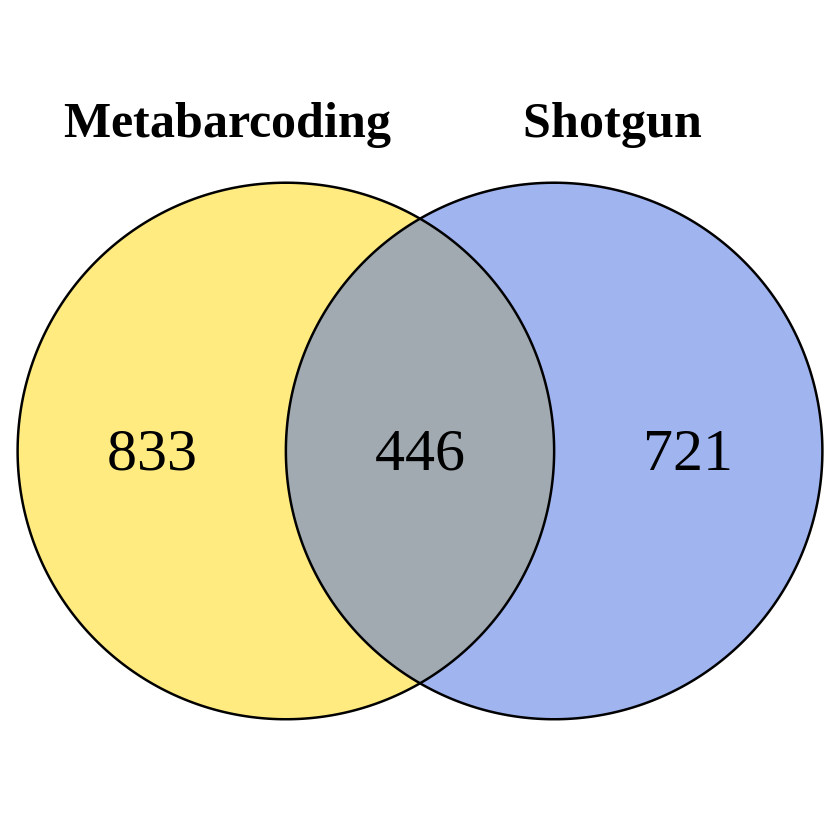

In [60]:
# Genus
gen_metabar <- unique(metbar$genus[!is.na(metbar$genus)])
gen_shotgun <- unique(shotgun_eu$genus[!is.na(shotgun_eu$genus)])
taxa <- list(metabarcoding = gen_metabar, shotgun_eu = gen_shotgun)

# Venn Diagram (Saved manually)
display_venn(taxa,
             category.names = c("Metabarcoding", "Shotgun"),
             fill = c("gold", "royalblue"),
             cex = 3,
             cat.cex = 2.5, cat.fontface = "bold",
             cat.pos = c(-10,10),
             cat.dist = c(0.05, 0.05),
             scaled = F)

In [62]:
# Phylum
phyl_metabar <- unique(metbar$phylum[!is.na(metbar$phylum)])
phyl_shotgun <- unique(shotgun_eu$phylum[!is.na(shotgun_eu$phylum)])
taxa <- list(metabarcoding = phyl_metabar, shotgun_eu = phyl_shotgun)

# Unique phyla
unq_metabar <- sort(taxa$metbar[!taxa$metbar %in% taxa$shotgun_eu])
unq_shotgun <- sort(taxa$shotgun_eu[!taxa$shotgun_eu %in% taxa$metbar])

# Phylum table
df <- data.frame(phylum = unique(c(phyl_metabar, phyl_shotgun)))

df <- df %>% mutate(meta = ifelse(df$phylum %in% phyl_metabar, "metabar", NA)) %>%
  mutate(shot = ifelse(df$phylum %in% phyl_shotgun, "shotgun", NA)) %>% 
  mutate(metabarcoding = ifelse(meta == "metabar", phylum, NA)) %>% 
  mutate(shotgun = ifelse(shot == "shotgun", phylum, NA)) %>% 
  select(metabarcoding, shotgun) %>% 
  arrange(shotgun)

# Presence absence table
rownames(df) <- ifelse(!is.na(df$metabarcoding), df$metabarcoding, df$shotgun )
df$metabarcoding <- ifelse(!is.na(df$metabarcoding), 1, 0)
df$shotgun <- ifelse(!is.na(df$shotgun), 1, 0)

# Recover phylum
df$phylum <- rownames(df)

# Order columns
df <- df[,c(3,1,2)]

# Share
df <- df %>% mutate(belonging = ifelse(metabarcoding == 1 & shotgun == 1, "shared",
                                 ifelse(metabarcoding == 1 & shotgun == 0, "metabarcoding","shotgun")))

write.table(df, "phylum_comparison_table.eukaryota.tsv", quote = F, row.names = F, sep="\t")

In [65]:
# Heatmap
dfm <- melt(df)
dfm$variable <- ifelse(dfm$variable == "shotgun", "Shotgun", "Metabarcoding")
dfm$value <- ifelse(dfm$value == 0, "Absence", "Presence")
dfm$phylum <- factor(dfm$phylum, levels = rev(sort(unique(dfm$phylum))))
p <- dfm %>% ggplot() + geom_tile(aes(x=variable, y=phylum), fill="gray60", color="black", alpha=0.8) +
# Shotgun
geom_tile(data=subset(dfm, belonging == "shotgun" & variable == "Shotgun"),
          aes(x=variable, y=phylum), fill="royalblue", color="black") +
geom_tile(data=subset(dfm, belonging == "shotgun" & variable == "Metabarcoding"),
          aes(x=variable, y=phylum), fill="gray90", color="white") +
# Metabarcoding
geom_tile(data=subset(dfm, belonging == "metabarcoding" & variable == "Metabarcoding"),
          aes(x=variable, y=phylum), fill="gold", color="black") +
geom_tile(data=subset(dfm, belonging == "metabarcoding" & variable == "Shotgun"),
          aes(x=variable, y=phylum), fill="gray90", color="white") +
labs(x = "", y = "Phylum", fill="") +
theme_classic() %+replace% theme(axis.text.x = element_text(size=18),
                                 axis.text.y = element_text(size=11),
                                 axis.title = element_text(size=20),
                                 legend.title = element_text(size=18, face="bold"),
                                 legend.text = element_text(size=16))

png(file="comp.Presence_Absence.phylum.png", width=2300, height=2500, res=300)
p
dev.off()

Using phylum, belonging as id variables



png 
  2

# Validation

In [67]:
arter <- read.table("arter.tsv", sep="\t", header=T)
colnames(arter) <- c("Phylum","Class","Order","Family","Genus","Species", "Marine")
marine <- arter[arter$Marine == "Yes",]

In [68]:
table(arter$Marine)


   No   Yes 
23567  2575 

In [69]:
unique(shotgun_taxa_count$kingdom)

[1] NA              "Fungi"         "Metazoa"       "Viridiplantae"

In [70]:
# Shotgun
ps <- shotgun_taxa_count %>% filter(superkingdom == "Eukaryota", kingdom == "Metazoa")
ps <- ps[,c(3,9:23)]
ps <- melt(ps) %>% group_by(phylum,variable) %>% summarise(value = sum(value)) %>%
mutate(origin = ifelse(phylum %in% marine$Phylum, "Danish", "Exotic"))

Using phylum as id variables

`summarise()` has grouped output by 'phylum'. You can override using the `.groups`
argument.


In [71]:
unique(ps$phylum[ps$phylum %in% marine$Phylum])
unique(ps$phylum[!ps$phylum %in% marine$Phylum])

[1] "Annelida"        "Arthropoda"      "Bryozoa"         "Chordata"       
 [5] "Cnidaria"        "Ctenophora"      "Echinodermata"   "Gastrotricha"   
 [9] "Hemichordata"    "Mollusca"        "Nematoda"        "Phoronida"      
[13] "Platyhelminthes" "Porifera"        "Priapulida"      "Rotifera"       
[17] "Xenacoelomorpha"

[1] "Placozoa"   "Tardigrada" NA

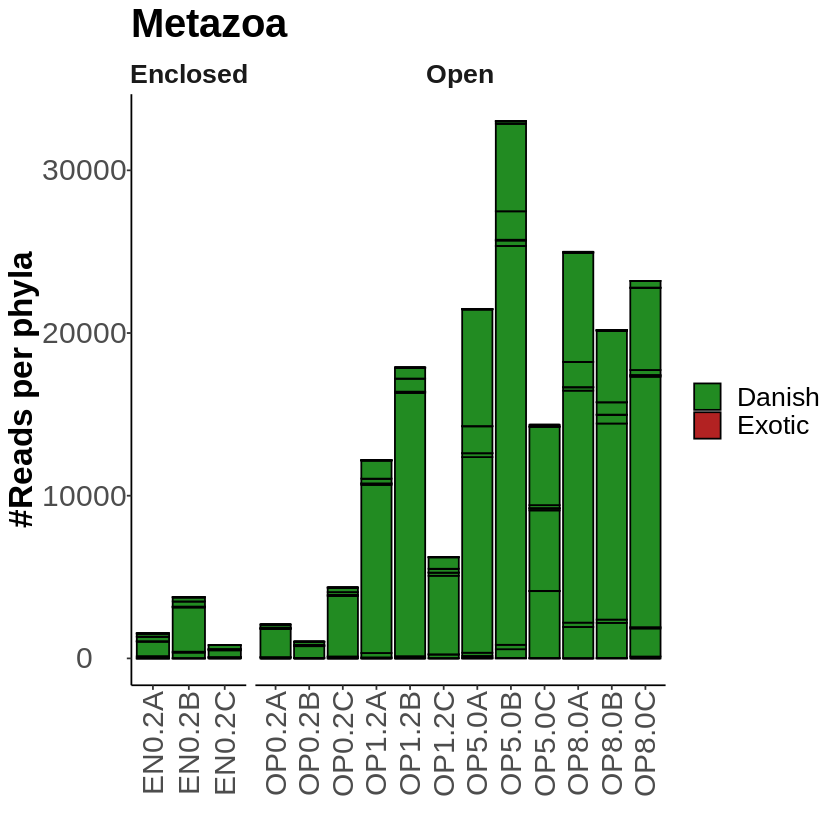

In [72]:
newnames <- c('EN0.2A','EN0.2B','EN0.2C','OP0.2A','OP0.2B','OP0.2C','OP1.2A','OP1.2B','OP1.2C','OP5.0A','OP5.0B','OP5.0C','OP8.0A','OP8.0B','OP8.0C')
ps$variable <- factor(ps$variable, levels = newnames)
ps <- ps %>% mutate(type = ifelse(grepl("EN", variable), "Enclosed", "Open"))

p <- ps %>% drop_na() %>%
ggplot() + geom_col(aes(x=variable, y=value, fill=origin), color="black") +
scale_fill_manual(values = c("forestgreen", "firebrick")) +
labs(fill = "", x="", y="#Reads per phyla", title="Metazoa") +
facet_wrap(~type, scales="free_x") +
theme_classic() %+replace% theme(
    title = element_text(size=20, face="bold"),
    axis.text.x = element_text(angle = 90, size=18),
    axis.text.y = element_text(size=18),
    axis.title = element_text(size=20),
    strip.text.x = element_text(size = 16, face="bold"),
    strip.background = element_blank(),
    legend.title = element_text(size=18, face="bold"),
    legend.text = element_text(size=16))

gt = ggplot_gtable(ggplot_build(p))
gt$widths[5] = 0.28*gt$widths[5]

#png(file="07-Plots/bars.spkm.raw.png", width=2300, height=2000, res=300)
grid.draw(gt)
#dev.off()

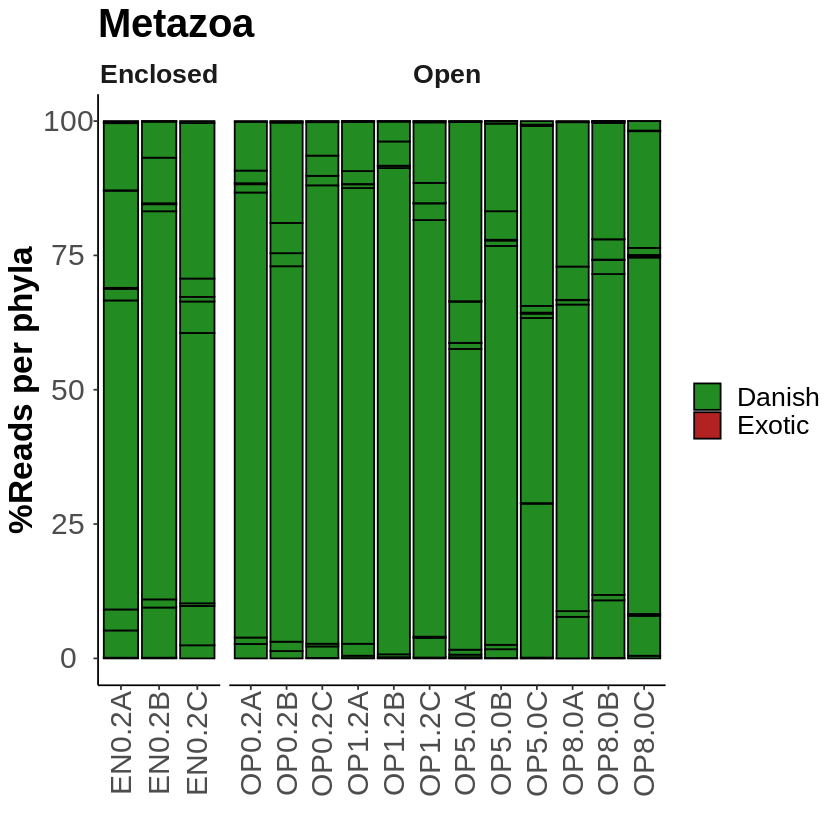

In [93]:
ps_perc <- ps %>% group_by(variable) %>% drop_na(phylum) %>%
filter(value != 0) %>% mutate(total = sum(value)) %>% ungroup() %>% 
mutate(perc = value / total * 100)

ps_perc$variable <- factor(ps_perc$variable, levels = newnames)
ps_perc <- ps_perc %>% mutate(type = ifelse(grepl("EN", variable), "Enclosed", "Open"))

p <- ps_perc %>% drop_na() %>%
ggplot() + geom_col(aes(x=variable, y=perc, fill=origin), color="black") +
scale_fill_manual(values = c("forestgreen", "firebrick")) +
labs(fill = "", x="", y="%Reads per phyla", title="Metazoa") +
facet_wrap(~type, scales="free_x") +
theme_classic() %+replace% theme(
    title = element_text(size=20, face="bold"),
    axis.text.x = element_text(angle = 90, size=18),
    axis.text.y = element_text(size=18),
    axis.title = element_text(size=20),
    strip.text.x = element_text(size = 16, face="bold"),
    strip.background = element_blank(),
    legend.title = element_text(size=18, face="bold"),
    legend.text = element_text(size=16))

gt = ggplot_gtable(ggplot_build(p))
gt$widths[5] = 0.28*gt$widths[5]

#png(file="07-Plots/bars.spkm.raw.png", width=2300, height=2000, res=300)
grid.draw(gt)
#dev.off()

In [96]:
ps_perc %>% select(variable, origin, perc) %>% group_by(variable,origin) %>% summarise(perc = sum(perc))

`summarise()` has grouped output by 'variable'. You can override using the `.groups`
argument.


variable,origin,perc
<fct>,<chr>,<dbl>
EN0.2A,Danish,99.93493819
EN0.2A,Exotic,0.06506181
EN0.2B,Danish,99.94680851
EN0.2B,Exotic,0.05319149
EN0.2C,Danish,100.00000000
OP0.2A,Danish,100.00000000
OP0.2B,Danish,100.00000000
OP0.2C,Danish,100.00000000
OP1.2A,Danish,100.00000000


`summarise()` has grouped output by 'variable'. You can override using the `.groups`
argument.


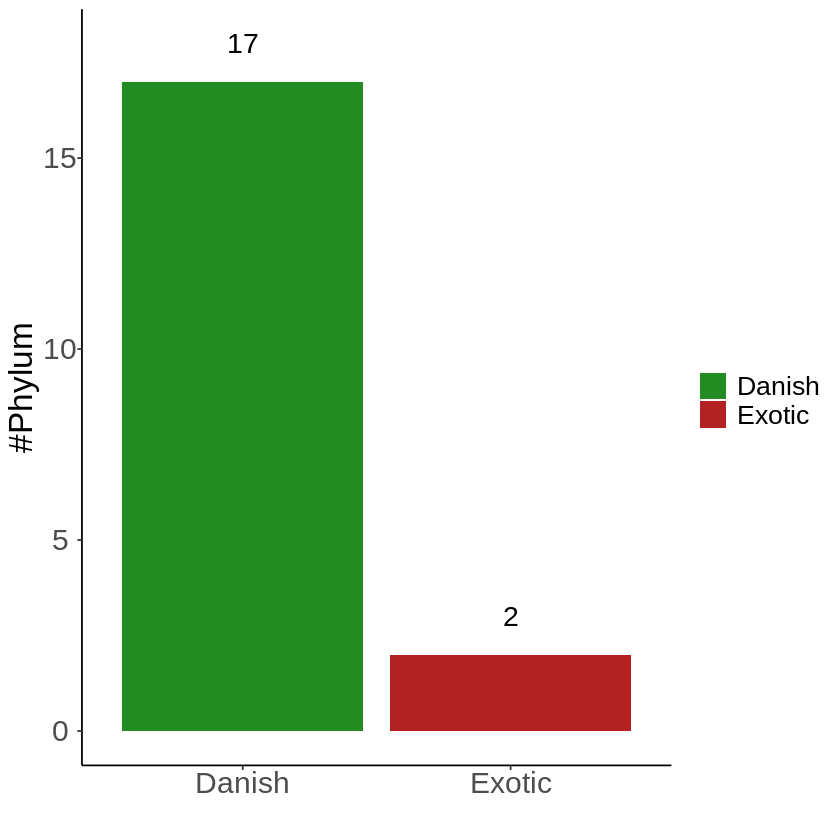

In [225]:
# Plot
ps %>% drop_na() %>% group_by(variable, origin) %>% summarise(count = n()) %>% ungroup() %>%
filter(variable == "OP0.2A") %>% 
ggplot() + geom_col(aes(x=origin, y=count, fill=origin)) +
geom_text(aes(x=origin, y=count+1, label=count), size=6) +
scale_fill_manual(values = c("forestgreen", "firebrick")) +
labs(fill = "", x="", y="#Phylum") +
theme_classic() %+replace% theme(axis.text.x = element_text(size=18),
                                 axis.text.y = element_text(size=18),
                                 axis.title = element_text(size=20),
                                 legend.text = element_text(size=16))

In [232]:
table(unique(marine$Phylum) %in% ps$phylum)


FALSE  TRUE 
    8    17 